In [1]:
import pandas as pd
import scipy
from scipy.stats import poisson
from scipy.stats import multinomial
from scipy.stats import norm
import warnings

import glob
import numpy as np
from tqdm import tqdm

from matplotlib import pyplot as plt
import matplotlib as mpl

In [2]:
def latex_float(f):
    float_str = "{0:.2g}".format(f)
    if "e" in float_str:
        base, exponent = float_str.split("e")
        return r"{0} \times 10^{{{1}}}".format(base, int(exponent))
    else:
        return float_str

In [3]:
path = "/home/felipe/JoaoPino/1-LQsCollider_project/Data_MadGraph/Full_data"

all_Signal = glob.glob(path + "/LQ_Tchannel_1p5TeV.csv")
all_ttbar = glob.glob(path + "/ttbar_*.csv")
all_WW = glob.glob(path + "/WW_*.csv")
all_ZZ = glob.glob(path + "/ZZ_*.csv")
all_ZW = glob.glob(path + "/ZW_*.csv")
all_Zplusjets = glob.glob(path + "/Z_plus_jets_*.csv")


In [4]:
li_Signal = []
li_ttbar = []
li_WW = []
li_ZZ = []
li_ZW = []
li_Zplusjets = []

#Signal
for filename in all_Signal:
    df = pd.read_csv(filename, index_col=None, header=0)
    li_Signal.append(df)

Signal = pd.concat(li_Signal, axis=0, ignore_index=True)

#ttbar
for filename in all_ttbar:
    df = pd.read_csv(filename, index_col=None, header=0)
    li_ttbar.append(df)

ttbar = pd.concat(li_ttbar, axis=0, ignore_index=True)

#WW
for filename in all_WW:
    df = pd.read_csv(filename, index_col=None, header=0)
    li_WW.append(df)

WW = pd.concat(li_WW, axis=0, ignore_index=True)

#ZZ
for filename in all_ZZ:
    df = pd.read_csv(filename, index_col=None, header=0)
    li_ZZ.append(df)

ZZ = pd.concat(li_ZZ, axis=0, ignore_index=True)

#ZW
for filename in all_ZW:
    df = pd.read_csv(filename, index_col=None, header=0)
    li_ZW.append(df)

ZW = pd.concat(li_ZW, axis=0, ignore_index=True)

#Z plus jets
for filename in all_Zplusjets:
    df = pd.read_csv(filename, index_col=None, header=0)
    li_Zplusjets.append(df)

Z_plus_jets = pd.concat(li_Zplusjets, axis=0, ignore_index=True)

Diboson = pd.concat([WW, ZZ, ZW],axis=0)

In [5]:
print("Available observables : \n\n {}".format(np.transpose(list(Diboson))))

Available observables : 

 ['pt_l1' 'pt_l2' 'E_l1' 'E_l2' 'eta_l1' 'eta_l2' 'phi_l1' 'phi_l2'
 'DeltaR_l1l2' 'DeltaPhi_l1l2' 'DeltaTheta_l1l2' 'DeltaEta_l1l2'
 'cos_l1l2' 'pt_l1_CM' 'pt_l2_CM' 'E_l1_CM' 'E_l2_CM' 'eta_l1_CM'
 'eta_l2_CM' 'phi_l1_CM' 'phi_l2_CM' 'DeltaR_l1l2_CM' 'DeltaPhi_l1l2_CM'
 'DeltaTheta_l1l2_CM' 'DeltaEta_l1l2_CM' 'cos_l1l2_CM' 'b2_l1l2' 'b4_l1l2'
 'M_l1l2' 'SpinCorr_Rcosl1' 'SpinCorr_Rcosl2' 'SpinCorr_Ncosl1'
 'SpinCorr_Ncosl2' 'mphi1' 'M_l1l2_CM' 'xs_weight']


In [6]:
number_of_bins = 30
Obs = 'pt_l1'
lumi = 300.

Get_events_background = Diboson[Obs].pipe(lambda s: pd.Series(np.histogram(s, range=(Diboson[Obs].min(), Diboson[Obs].max()), bins=number_of_bins, weights=Diboson['xs_weight']*1000*lumi)))[0] + \
                     Z_plus_jets[Obs].pipe(lambda s: pd.Series(np.histogram(s, range=(Diboson[Obs].min(), Diboson[Obs].max()), bins=number_of_bins, weights=Z_plus_jets['xs_weight']*1000*lumi)))[0] + \
                     ttbar[Obs].pipe(lambda s: pd.Series(np.histogram(s, range=(Diboson[Obs].min(), Diboson[Obs].max()), bins=number_of_bins, weights=ttbar['xs_weight']*1000*lumi)))[0]
Get_events_background = np.array([int(s) for s in Get_events_background])

Get_events_signal = Signal[Obs].pipe(lambda s: pd.Series(np.histogram(s, range=(Diboson[Obs].min(), Signal[Obs].max()), bins=number_of_bins, weights=Signal['xs_weight']*1000*lumi)))[0]
Get_events_signal = np.array([int(s) for s in Get_events_signal])

print("Number of expected background events/bin: \n {}".format(Get_events_background))
print("\n")
print("Number of expected signal events/bin: \n {}".format(Get_events_signal))
print("\n")
print("Number of expected signal + background events \n {}".format(Get_events_background + Get_events_signal))


Number of expected background events/bin: 
 [2110876034   41983349    6196867    1528747     514771     196578
     109457      27366      39312       1574        295        265
      12883         25          8          9          7          0
          2          6          2          0          0      12384
          0          0          0          0          0          0]


Number of expected signal events/bin: 
 [423 646 567 433 372 246 185 104 101  57  42  29  26   8  11   7   5   2
   2   0   1   1   0   0   0   0   0   0   0   0]


Number of expected signal + background events 
 [2110876457   41983995    6197434    1529180     515143     196824
     109642      27470      39413       1631        337        294
      12909         33         19         16         12          2
          4          6          3          1          0      12384
          0          0          0          0          0          0]


# Generate Poisson equivalent distributions for signal and backgrounds

In [7]:
Features = ['Log_prob_S', 'Log_prob_B', 'Log_probM_S', 'Log_probM_B']

df = pd.DataFrame(columns=Features)

#Number of pseudo experiments
N = 100_000

#Arrays with the number of background events and the number of signal+background events
Background = Get_events_background
Signal_plus_background = Get_events_background + Get_events_signal

#Up to which bins to use
number_of_bins = np.where(Get_events_background == 0)[0][0]

for idx in tqdm(range(0, N)):
    
    #if idx == 10:
    #    break
    
    with warnings.catch_warnings():
        warnings.filterwarnings('error')
        try:
    
            # ----- Signal -----
            # Create new data that is poisson distributed based on the orignal simulated one
            New_events_signal = np.array([ np.random.poisson(Signal_plus_background[i]) for i in range(0, number_of_bins) ])

            # For the background, stay fixed
            New_events_background = Background

            # ----- Get probabilities ----- 
            Get_probabilities_poisson_S = np.array([poisson.logpmf(k=New_events_signal[n], mu=New_events_background[n]) for n in range(0,number_of_bins)])    
            Get_probabilities_poisson_B = np.array([poisson.logpmf(k=New_events_background[n], mu=New_events_signal[n]) for n in range(0,number_of_bins)])
            
            Get_probabilities_multinomial_S = multinomial.logpmf(x=New_events_signal[:number_of_bins], n=New_events_signal[:number_of_bins].sum(), p=Get_probabilities_poisson_S) 
            Get_probabilities_multinomial_B = multinomial.logpmf(x=New_events_background[:number_of_bins], n=New_events_background[:number_of_bins].sum(), p=Get_probabilities_poisson_B)
            
            Get_product_S = np.prod(Get_probabilities_poisson_S, where=( (Get_probabilities_poisson_S != 0) & (Get_probabilities_poisson_S != np.inf) & (Get_probabilities_poisson_S != -np.inf) ))
            Get_product_B = np.prod(Get_probabilities_poisson_B, where=( (Get_probabilities_poisson_B != 0) & (Get_probabilities_poisson_B != np.inf) & (Get_probabilities_poisson_B != -np.inf) ))
            Get_prob_S = np.log(Get_product_S/Get_product_B)
            Get_probM_S = np.log(Get_probabilities_multinomial_S/Get_probabilities_multinomial_B)

            # For the background, stay fixed
            New_events_background = np.array([ np.random.poisson(Background[i]) for i in range(0, number_of_bins) ])
            New_events_signal = Signal_plus_background

            # ----- Get probabilities ----- 
            Get_probabilities_poisson_S = np.array([poisson.logpmf(k=New_events_background[n], mu=New_events_signal[n]) for n in range(0,number_of_bins)])    
            Get_probabilities_poisson_B = np.array([poisson.logpmf(k=New_events_signal[n], mu=New_events_background[n]) for n in range(0,number_of_bins)])
            
            Get_probabilities_multinomial_S = multinomial.logpmf(x=New_events_background[:number_of_bins], n=New_events_background[:number_of_bins].sum(), p=Get_probabilities_poisson_S) 
            Get_probabilities_multinomial_B = multinomial.logpmf(x=New_events_signal[:number_of_bins], n=New_events_signal[:number_of_bins].sum(), p=Get_probabilities_poisson_B)
            
            
            Get_product_S = np.prod(Get_probabilities_poisson_S, where=( (Get_probabilities_poisson_S != 0) & (Get_probabilities_poisson_S != np.inf) & (Get_probabilities_poisson_S != -np.inf) ))
            Get_product_B = np.prod(Get_probabilities_poisson_B, where=( (Get_probabilities_poisson_B != 0) & (Get_probabilities_poisson_B != np.inf) & (Get_probabilities_poisson_B != -np.inf) ))
            Get_prob_B = np.log(Get_product_S/Get_product_B)
            Get_probM_B = np.log(Get_probabilities_multinomial_S/Get_probabilities_multinomial_B)

            Obs = [Get_prob_S, Get_prob_B, Get_probM_S, Get_probM_B]

            # Save data data into a dataframe for further manipulation (df_S)
            entry = pd.DataFrame([Obs], columns=Features)
            df = df.append(entry)

        except Warning as e:
            continue




100%|██████████| 100000/100000 [07:26<00:00, 223.90it/s]


# Plots

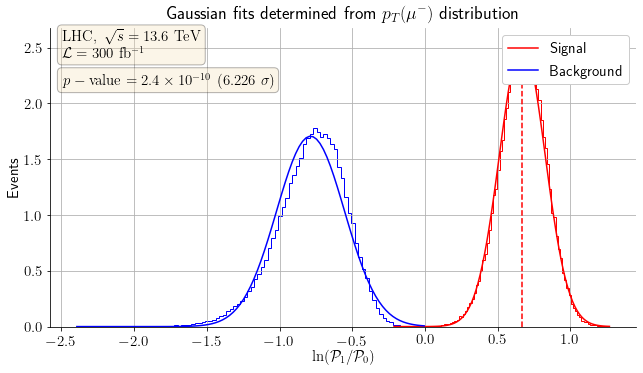

In [8]:
mpl.rcParams['text.usetex']=True 
mpl.rcParams['text.latex.preamble'] = r'\usepackage{bm}'
plt.rcParams.update({'font.size': 15})
mpl.rcParams["legend.framealpha"] = 1.0
mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.top'] = False
mpl.rcParams["figure.figsize"] = [10.5, 5.5]

f, ax = plt.subplots()

#Get bins for gaussian fit
_, bins_S, _ = plt.hist(df['Log_prob_S'].to_numpy(), bins=100, density=1 , alpha=0.5)
_, bins_B, _ = plt.hist(df['Log_prob_B'].to_numpy(), bins=100, density=1 , alpha=0.5)
#Close so plots are not drawn
plt.clf()

#Signal plot
mu_S, sigma_S = scipy.stats.norm.fit(df['Log_prob_S'].to_numpy())
best_fit_line_S = scipy.stats.norm.pdf(bins_S, mu_S, sigma_S)
df['Log_prob_S'].hist(bins=100, color='red', histtype = 'step', density=True)
plt.plot(bins_S, best_fit_line_S, '-r')

#Background plot
mu_B, sigma_B = scipy.stats.norm.fit(df['Log_prob_B'].to_numpy())
best_fit_line_B = scipy.stats.norm.pdf(bins_B, mu_B, sigma_B)
df['Log_prob_B'].hist(bins=100, color='blue', histtype = 'step', density=True)
plt.plot(bins_B, best_fit_line_B, '-b')

#Calculate p-value and translate to sigmas
p_value = 1 - norm.cdf(mu_S, mu_B, sigma_B)
sigma = (mu_S - mu_B)/sigma_B


plt.legend(['Signal', 'Background'], loc='upper right')
plt.grid("on")
plt.ylabel('Events')
plt.xlabel(r'$\ln(\mathcal{P}_1/\mathcal{P}_0)$')
plt.title(r'Gaussian fits determined from $p_T (\mu^-)$ distribution')
plt.plot(np.ones(100)*mu_S, np.linspace(0,max(best_fit_line_S),100), '--r')

props = dict(boxstyle='round', facecolor='wheat', alpha=0.3)
plt.text(0.02, 0.90, '$\mathrm{{LHC}},~\sqrt{{s}} = 13.6~\mathrm{{TeV}}$ \n $\mathcal{{L}}={l}~\mathrm{{fb^{{-1}}}}$'.format(l=int(lumi)), transform=plt.gca().transAxes, bbox=props)
if p_value == 0.0:
    plt.text(0.02, 0.81, '$p-\mathrm{{value}} = 0.0000\dots~({0:.3f}~\sigma)$'.format(sigma), transform=plt.gca().transAxes, bbox=props)
elif p_value != 0.0:
    plt.text(0.02, 0.81, '$p-\mathrm{{value}} = {a}~({b}~\sigma)$'.format(a=latex_float(p_value), b=np.round(sigma,3)), transform=plt.gca().transAxes, bbox=props)
    
#plt.ylim(0, 200)    
plt.show()
#plt.savefig('/home/felipe/JoaoPino/1-LQsCollider_project/Plots/pT_mu_100k_pseudo_3000fb.pdf')
